In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # Check if CUDA is available (if applicable)

2.7.0
False


In [2]:
import torch
import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import cv2
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import v2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import time
import os
import PIL
from PIL import Image
cudnn.benchmark = True


device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [3]:
BASE_DIR = "Desktop/ResearchAlzheimers/Alzheimer MRI Disease Classification Dataset/Data"
disease_label_from_category = {
    0: "Mild Demented",
    1: "Moderate Demented",
    2: "Non Demented",
    3: "Very Mild Demented",
}

In [4]:
df = pd.read_parquet("/Users/jessicakammann/Desktop/Alzheimer2/CompetitingTechnologies/Desktop/ResearchAlzheimers/Alzheimer MRI Disease Classification Dataset/Data/train-00000-of-00001-c08a401c53fe5312.parquet", engine="pyarrow")
df.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


In [5]:
test = pd.read_parquet("/Users/jessicakammann/Desktop/ResearchAlzheimers/Alzheimer MRI Disease Classification Dataset/Data/test-00000-of-00001-44110b9df98c5585.parquet", engine="pyarrow")

In [6]:
def dict_to_image(image_dict):
    if isinstance(image_dict, dict) and 'bytes' in image_dict:
        byte_string = image_dict['bytes']
        nparr = np.frombuffer(byte_string, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
        return img
    else:
        raise TypeError(f"Expected dictionary with 'bytes' key, got {type(image_dict)}")
    #takes it out of parquet format into an image format

In [7]:
df['img_arr'] = df['image'].apply(dict_to_image)
df.drop("image", axis=1, inplace=True)
df.head()

,label,img_arr
0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [8]:
test['img_arr'] = test['image'].apply(dict_to_image)
test.drop("image", axis=1, inplace=True)

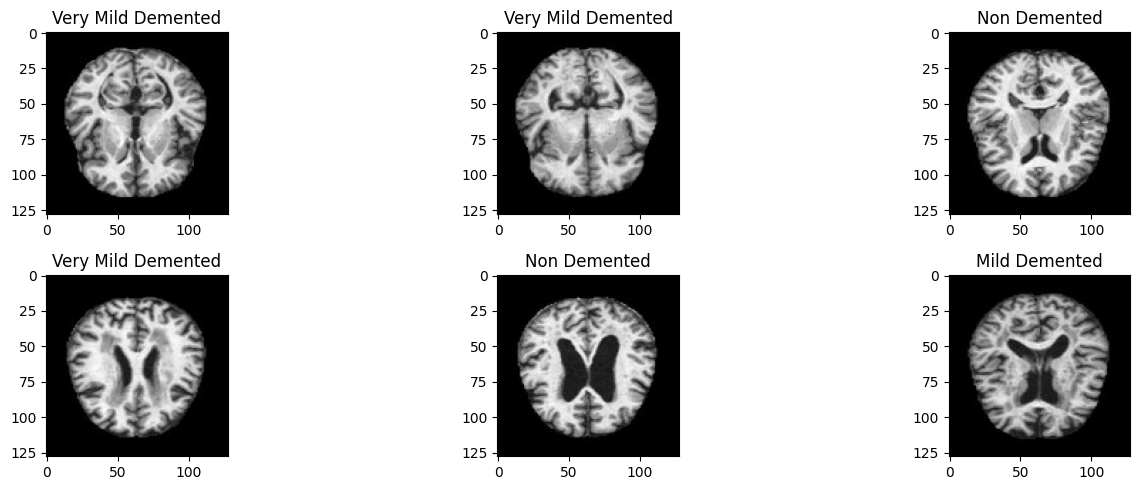

In [9]:
# Check we can actually render the image and that it looks reasonable
fig, ax = plt.subplots(2, 3, figsize=(15, 5))
axs = ax.flatten()
for axes in axs:
    rand = np.random.randint(0, len(df))
    axes.imshow(df.iloc[rand]['img_arr'], cmap="gray")
    axes.set_title(disease_label_from_category[df.iloc[rand]['label']])
plt.tight_layout()
plt.show()

In [10]:
class ImageDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        image = self.dataframe.iloc[idx]["img_arr"] # Get the label from the df
        label = self.dataframe.iloc[idx]["label"] # Get the img numpy array from the df
        # The CNN requires we add a channel dimension i.e. (128, 128) -> (1, 128, 128)
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

In [11]:
#Turn it into a PyTorch File
# Create dataset and dataloader
batch_size= 32
train_dataset = ImageDataset(df)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = ImageDataset(test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [23]:
import torch
import torch.nn as nn

class UNetClassifier(nn.Module):
    def __init__(self, in_channels=3, num_classes=4):
        super(UNetClassifier, self).__init__()
        
        # Contracting path
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)
        
        # Expanding path
        self.upconv4 = self.upconv(1024, 512)
        self.dec4 = self.conv_block(1024, 512)
        self.upconv3 = self.upconv(512, 256)
        self.dec3 = self.conv_block(512, 256)
        self.upconv2 = self.upconv(256, 128)
        self.dec2 = self.conv_block(256, 128)
        self.upconv1 = self.upconv(128, 64)
        self.dec1 = self.conv_block(128, 64)
        
        # Global Average Pooling
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # Reduce spatial dimensions to 1x1
        
        # Fully connected layer for classification
        self.fc = nn.Linear(64, num_classes)  # Map to the number of classes
    
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def upconv(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
    
    def forward(self, x):
        # Contracting path
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.downsample(enc1))
        enc3 = self.enc3(self.downsample(enc2))
        enc4 = self.enc4(self.downsample(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.downsample(enc4))
        
        # Expanding path
        dec4 = self.dec4(torch.cat((self.upconv4(bottleneck), enc4), dim=1))
        dec3 = self.dec3(torch.cat((self.upconv3(dec4), enc3), dim=1))
        dec2 = self.dec2(torch.cat((self.upconv2(dec3), enc2), dim=1))
        dec1 = self.dec1(torch.cat((self.upconv1(dec2), enc1), dim=1))
        
        # Global Average Pooling
        pooled = self.global_pool(dec1)  # Shape: [batch_size, 64, 1, 1]
        pooled = pooled.view(pooled.size(0), -1)  # Flatten to [batch_size, 64]
        
        # Fully connected layer
        output = self.fc(pooled)  # Shape: [batch_size, num_classes]
        
        return output
    
    def downsample(self, x):
        return nn.MaxPool2d(kernel_size=2, stride=2)(x)

In [24]:
#Prepare Dataset 
from torch.utils.data import Dataset
from PIL import Image
import os

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])
        
        image = Image.open(img_path).convert("RGB")  # Convert image to RGB
        mask = Image.open(mask_path).convert("L")  # Convert mask to grayscale
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        # Add a channel dimension to the mask
        mask = mask.unsqueeze(0)  # Shape: [1, height, width]
        
        return image, mask

In [25]:
## Define Transforms 
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [26]:
## Data Loaders 
from torch.utils.data import DataLoader
train_dataset = ImageDataset(df)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = ImageDataset(test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [32]:
#Define U-Net 
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetClassifier(in_channels=1).to(device)
criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classificatio
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, masks in tqdm.tqdm(train_loader): #added tqdm.tqdm(train_loader) was just train_loader before
        images, masks = images.to(device), masks.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader)}")

Epoch 1/1, Loss: 1.018888183310628


In [35]:
#Validate the Model 
model.eval()
with torch.no_grad():
    for images, masks in tqdm.tqdm(test_loader): #added tqdm.tqdm(val_loader) was just val_loader before
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs) > 0.5  # Threshold for binary segmentation

Images shape: (32, 1, 128, 128)
Masks shape: (32,)
Predictions shape: (32, 1, 128, 128)


IndexError: too many indices for array: array is 1-dimensional, but 4 were indexed

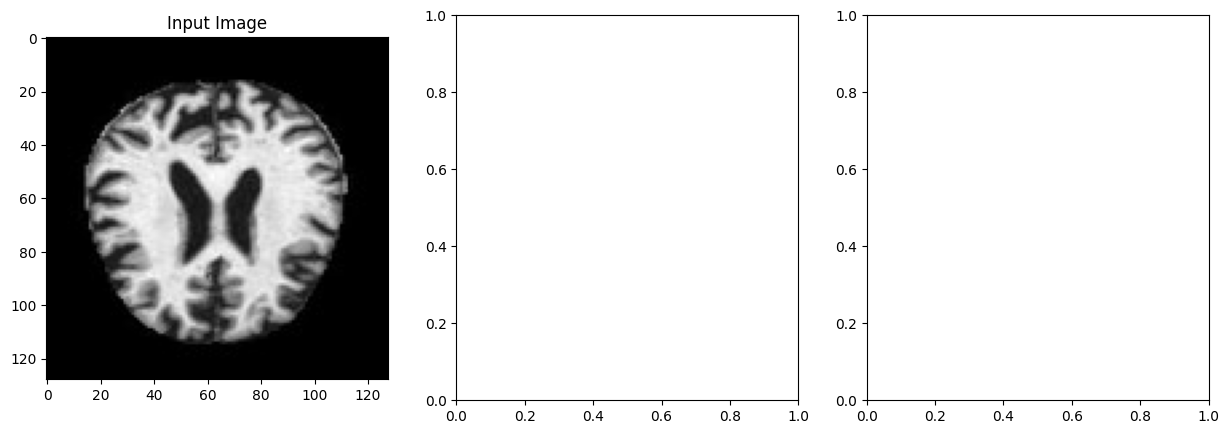

In [48]:
# Save the model
model = UNet(in_channels=1, out_channels=1)
torch.save(model.state_dict(), "unet_model.pth")

# Load the model
model = UNet(in_channels=1, out_channels=1)
model.load_state_dict(torch.load("unet_model.pth"))
model.eval()

# Visualize predictions
def visualize_predictions(model, dataloader, num_images=5):
    model.eval()
    with torch.no_grad():
        for i, (images, masks) in enumerate(dataloader):
            if i >= num_images:
                break
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5  # Threshold for binary segmentation
            
            # Convert to numpy for visualization
            images_np = images.cpu().numpy()
            masks_np = masks.cpu().numpy()
            preds_np = preds.cpu().numpy()
            
            # Debug shapes
            print(f"Images shape: {images_np.shape}")
            print(f"Masks shape: {masks_np.shape}")
            print(f"Predictions shape: {preds_np.shape}")
            
            # Plotting
            for j in range(min(len(images_np), num_images)):
                fig, ax = plt.subplots(1, 3, figsize=(15, 5))
                
                # Input image (grayscale)
                ax[0].imshow(images_np[j, 0, :, :], cmap='gray')  # Use the first channel
                ax[0].set_title('Input Image')
                
                # Ground truth mask
                ax[1].imshow(masks_np[j, 0, :, :], cmap='gray')  # Use the first channel
                ax[1].set_title('Ground Truth Mask')
                
                # Predicted mask
                ax[2].imshow(preds_np[j, 0, :, :], cmap='gray')  # Use the first channel
                ax[2].set_title('Predicted Mask')
                
                plt.show()

# Test the model
visualize_predictions(model, test_loader, num_images=5)